# Data Preprocessing

## 1. Introduction

In this notebook, we will preprocess the data to make it ready for the model. We will focus on data cleaning, integration, and aggregation. We will discuss methodologies investigated and chosen for handling of missing values, feature engineering, and feature selection.

## 2. Import Required Libraries

In [149]:
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

# Load the environment variables
load_dotenv("../config/.env")

scripts_path = os.getenv("SCRIPTS_PATH")

# Add the path to the scripts folder and import the functions
if scripts_path not in sys.path:
    sys.path.append(scripts_path)

In [4]:
# from merged_data import get_weather_migraine_dataframe
from raw_data import get_raw_dataframes

## 3. Load Data

In [5]:
# Load data
city_data, country_data, weather_data, migraine_data = get_raw_dataframes()

city_data.shape, country_data.shape, weather_data.shape, migraine_data.shape

((1245, 8), (214, 11), (27635763, 14), (13770, 16))

## 4. Data Cleaning

### 4.1 Drop Unnecessary Columns/Rows

#### 4.1.1 DataFrame: `city_data`

In [6]:
city_data

,station_id,city_name,country,state,iso2,iso3,latitude,longitude
0,41515,Asadabad,Afghanistan,Kunar,AF,AFG,34.866000,71.150005
1,38954,Fayzabad,Afghanistan,Badakhshan,AF,AFG,37.129761,70.579247
2,41560,Jalalabad,Afghanistan,Nangarhar,AF,AFG,34.441527,70.436103
3,38947,Kunduz,Afghanistan,Kunduz,AF,AFG,36.727951,68.872530
4,38987,Qala i Naw,Afghanistan,Badghis,AF,AFG,34.983000,63.133300
...,...,...,...,...,...,...,...,...
1240,67475,Kasama,Zambia,Northern,ZM,ZMB,-10.199598,31.179947
1241,68030,Livingstone,Zambia,Southern,ZM,ZMB,-17.860009,25.860013
1242,67633,Mongu,Zambia,Western,ZM,ZMB,-15.279598,23.120025
1243,67775,Harare,Zimbabwe,Harare,ZW,ZWE,-17.817790,31.044709


Keeping all columns for now.

#### 4.1.2 DataFrame: `country_data`

In [7]:
country_data

,country,native_name,iso2,iso3,population,area,capital,capital_lat,capital_lng,region,continent
0,Afghanistan,افغانستان,AF,AFG,26023100.0,652230.0,Kabul,34.526011,69.177684,Southern and Central Asia,Asia
1,Albania,Shqipëria,AL,ALB,2895947.0,28748.0,Tirana,41.326873,19.818791,Southern Europe,Europe
2,Algeria,الجزائر,DZ,DZA,38700000.0,2381741.0,Algiers,36.775361,3.060188,Northern Africa,Africa
3,American Samoa,American Samoa,AS,ASM,55519.0,199.0,Pago Pago,-14.275479,-170.704830,Polynesia,Oceania
4,Angola,Angola,AO,AGO,24383301.0,1246700.0,Luanda,-8.827270,13.243951,Central Africa,Africa
...,...,...,...,...,...,...,...,...,...,...,...
209,Wallis and Futuna,Wallis et Futuna,WF,WLF,13135.0,142.0,Mata-Utu,-13.282042,-176.174022,Polynesia,Oceania
210,Western Sahara,الصحراء الغربية,EH,ESH,586000.0,266000.0,El Aaiún,27.154512,-13.195392,Northern Africa,Africa
211,Yemen,اليَمَن,YE,YEM,25956000.0,527968.0,Sana'a,15.353857,44.205884,Middle East,Asia
212,Zambia,Zambia,ZM,ZMB,15023315.0,752612.0,Lusaka,-15.416449,28.282154,Eastern Africa,Europe


*Keeping* the following columns:
- 'country'
- 'iso2'
- 'iso3'
- 'population'
- 'region'
- 'continent'

*Removing* the following columns:
- 'native_name'
- 'area'
- 'capital'
- 'capital_lat'
- 'capital_lon'

In [8]:
# Drop columns that are not needed for the analysis
country_data.drop(columns=['native_name', 'area', 'capital', 'capital_lat', 'capital_lng'], inplace=True)
country_data.shape

(214, 6)

In [9]:
country_data

,country,iso2,iso3,population,region,continent
0,Afghanistan,AF,AFG,26023100.0,Southern and Central Asia,Asia
1,Albania,AL,ALB,2895947.0,Southern Europe,Europe
2,Algeria,DZ,DZA,38700000.0,Northern Africa,Africa
3,American Samoa,AS,ASM,55519.0,Polynesia,Oceania
4,Angola,AO,AGO,24383301.0,Central Africa,Africa
...,...,...,...,...,...,...
209,Wallis and Futuna,WF,WLF,13135.0,Polynesia,Oceania
210,Western Sahara,EH,ESH,586000.0,Northern Africa,Africa
211,Yemen,YE,YEM,25956000.0,Middle East,Asia
212,Zambia,ZM,ZMB,15023315.0,Eastern Africa,Europe


#### 4.1.3 DataFrame: `weather_data`

In [10]:
weather_data

,station_id,city_name,date,season,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh,peak_wind_gust_kmh,avg_sea_level_pres_hpa,sunshine_total_min
0,41515,Asadabad,1957-07-01,Summer,27.0,21.1,35.6,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,41515,Asadabad,1957-07-02,Summer,22.8,18.9,32.2,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,41515,Asadabad,1957-07-03,Summer,24.3,16.7,35.6,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,41515,Asadabad,1957-07-04,Summer,26.6,16.1,37.8,4.1,NaN,NaN,NaN,NaN,NaN,NaN
4,41515,Asadabad,1957-07-05,Summer,30.8,20.0,41.7,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24216,67975,Masvingo,2023-09-01,Spring,19.5,9.6,28.4,NaN,NaN,180.0,4.6,NaN,NaN,NaN
24217,67975,Masvingo,2023-09-02,Spring,21.3,10.5,31.4,NaN,NaN,146.0,6.3,NaN,NaN,NaN
24218,67975,Masvingo,2023-09-03,Spring,22.1,13.0,31.5,NaN,NaN,147.0,8.2,NaN,NaN,NaN
24219,67975,Masvingo,2023-09-04,Spring,21.5,13.1,29.7,NaN,NaN,155.0,10.2,NaN,NaN,NaN


*Keeping* the following columns:
- 'station_id'
- 'city_name'
- 'date'
- '*_temp_c' (avg, min, max)
- 'precipitation_mm'
- 'avg_sea_level_pres_hpa'
- 'sunshine_total_min'

*Removing* the following columns:
- 'season'
- 'snow_depth_mm'
- 'avg_wind_dir_deg'
- 'avg_wind_speed_kmh'
- 'peak_wind_gust_kmh'


In [11]:
# Drop columns that are not needed for the analysis
weather_data.drop(columns=['season', 'snow_depth_mm', 'avg_wind_dir_deg', 'avg_wind_speed_kmh', 'peak_wind_gust_kmh'], inplace=True)
weather_data.shape

(27635763, 9)

In [12]:
weather_data

,station_id,city_name,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,avg_sea_level_pres_hpa,sunshine_total_min
0,41515,Asadabad,1957-07-01,27.0,21.1,35.6,0.0,NaN,NaN
1,41515,Asadabad,1957-07-02,22.8,18.9,32.2,0.0,NaN,NaN
2,41515,Asadabad,1957-07-03,24.3,16.7,35.6,1.0,NaN,NaN
3,41515,Asadabad,1957-07-04,26.6,16.1,37.8,4.1,NaN,NaN
4,41515,Asadabad,1957-07-05,30.8,20.0,41.7,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
24216,67975,Masvingo,2023-09-01,19.5,9.6,28.4,NaN,NaN,NaN
24217,67975,Masvingo,2023-09-02,21.3,10.5,31.4,NaN,NaN,NaN
24218,67975,Masvingo,2023-09-03,22.1,13.0,31.5,NaN,NaN,NaN
24219,67975,Masvingo,2023-09-04,21.5,13.1,29.7,NaN,NaN,NaN


#### 4.1.4 DataFrame: `migraine_data`

In [13]:
migraine_data

,measure_id,measure_name,location_id,location_name,sex_id,sex_name,age_id,age_name,cause_id,cause_name,metric_id,metric_name,year,val,upper,lower
0,3,YLDs (Years Lived with Disability),546,Minnesota,3,Both,22,All ages,547,Migraine,1,Number,1990,29214.944775,65881.324298,4214.353272
1,3,YLDs (Years Lived with Disability),546,Minnesota,3,Both,22,All ages,547,Migraine,2,Percent,1990,0.049052,0.103676,0.007819
2,3,YLDs (Years Lived with Disability),546,Minnesota,3,Both,22,All ages,547,Migraine,3,Rate,1990,654.931108,1476.906050,94.475998
3,3,YLDs (Years Lived with Disability),546,Minnesota,3,Both,22,All ages,547,Migraine,1,Number,1991,29442.341790,67467.950066,4364.104506
4,3,YLDs (Years Lived with Disability),546,Minnesota,3,Both,22,All ages,547,Migraine,2,Percent,1991,0.049217,0.103733,0.007876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13765,6,Incidence,573,Wyoming,3,Both,22,All ages,547,Migraine,2,Percent,2018,0.002238,0.002539,0.001959
13766,6,Incidence,573,Wyoming,3,Both,22,All ages,547,Migraine,3,Rate,2018,1147.054257,1274.028193,1013.596884
13767,6,Incidence,573,Wyoming,3,Both,22,All ages,547,Migraine,1,Number,2019,6991.165889,7765.510653,6179.168968
13768,6,Incidence,573,Wyoming,3,Both,22,All ages,547,Migraine,2,Percent,2019,0.002144,0.002442,0.001875


*Keeping* only the following columns:
- 'measure_name'
- 'location_name'
- 'sex_name'
- 'age_name'
- 'cause_name'
- 'metric_name'
- 'year'
- 'val'
- 'upper'
- 'lower'

*Removing* the following columns:
- '*_id' (measure, location, sex, age, cause, metric)

In [14]:
# Drop columns that are not needed for the analysis
migraine_data.drop(columns=['measure_id', 'location_id', 'sex_id', 'age_id', 'cause_id', 'metric_id'], inplace=True)
migraine_data.shape

(13770, 10)

In [15]:
# Ensure specified columns are dropped
migraine_data

,measure_name,location_name,sex_name,age_name,cause_name,metric_name,year,val,upper,lower
0,YLDs (Years Lived with Disability),Minnesota,Both,All ages,Migraine,Number,1990,29214.944775,65881.324298,4214.353272
1,YLDs (Years Lived with Disability),Minnesota,Both,All ages,Migraine,Percent,1990,0.049052,0.103676,0.007819
2,YLDs (Years Lived with Disability),Minnesota,Both,All ages,Migraine,Rate,1990,654.931108,1476.906050,94.475998
3,YLDs (Years Lived with Disability),Minnesota,Both,All ages,Migraine,Number,1991,29442.341790,67467.950066,4364.104506
4,YLDs (Years Lived with Disability),Minnesota,Both,All ages,Migraine,Percent,1991,0.049217,0.103733,0.007876
...,...,...,...,...,...,...,...,...,...,...
13765,Incidence,Wyoming,Both,All ages,Migraine,Percent,2018,0.002238,0.002539,0.001959
13766,Incidence,Wyoming,Both,All ages,Migraine,Rate,2018,1147.054257,1274.028193,1013.596884
13767,Incidence,Wyoming,Both,All ages,Migraine,Number,2019,6991.165889,7765.510653,6179.168968
13768,Incidence,Wyoming,Both,All ages,Migraine,Percent,2019,0.002144,0.002442,0.001875


In [16]:
# Check the unique values of the measure_name column
migraine_data['measure_name'].unique()

array(['YLDs (Years Lived with Disability)', 'Prevalence', 'Incidence'],
      dtype=object)

In [17]:
# Check the unique values of the metric_name column
migraine_data['metric_name'].unique()

array(['Number', 'Percent', 'Rate'], dtype=object)

For this analysis, we will only be looking at the prevalence (total # of cases in the population) of migraine, so we will remove all other rows. In addition, we will remove all percent and rate values, as we are only interested in the total number of cases.

In [18]:
# Filter the data to only include the prevalence and number of migraine

# Identify indices to drop for both 'measure_name' and 'metric_name'
measure_indices_to_drop = migraine_data[migraine_data['measure_name'].isin(['YLDs (Years Lived with Disability)', 'Incidence'])].index
metric_indices_to_drop = migraine_data[migraine_data['metric_name'].isin(['Percent', 'Rate'])].index

# Combine the indices
all_indices_to_drop = measure_indices_to_drop.union(metric_indices_to_drop)

# Drop rows
filtered_migraine_data = migraine_data.drop(all_indices_to_drop)

# Format values in the val, upper, and lower columns to two decimal places
pd.set_option('display.float_format', lambda x:'%.2f' % x)

filtered_migraine_data

,measure_name,location_name,sex_name,age_name,cause_name,metric_name,year,val,upper,lower
4590,Prevalence,Maryland,Both,All ages,Migraine,Number,1990,899891.77,1021685.15,795767.14
4593,Prevalence,Maryland,Both,All ages,Migraine,Number,1991,906877.62,1030881.15,801568.81
4596,Prevalence,Maryland,Both,All ages,Migraine,Number,1992,912168.63,1034702.70,806243.62
4599,Prevalence,Maryland,Both,All ages,Migraine,Number,1993,916247.84,1039830.53,808396.09
4602,Prevalence,Maryland,Both,All ages,Migraine,Number,1994,919922.42,1045489.59,811418.83
...,...,...,...,...,...,...,...,...,...,...
9165,Prevalence,Wyoming,Both,All ages,Migraine,Number,2015,99965.80,114235.29,87503.39
9168,Prevalence,Wyoming,Both,All ages,Migraine,Number,2016,100533.94,114824.34,87970.08
9171,Prevalence,Wyoming,Both,All ages,Migraine,Number,2017,101085.56,115425.64,88418.20
9174,Prevalence,Wyoming,Both,All ages,Migraine,Number,2018,101611.76,116017.82,88899.17


In [118]:
# Rename `location_name` in migraine_data to `state`
filtered_migraine_data.rename(columns={'location_name': 'state'}, inplace=True)

filtered_migraine_data

,measure_name,state,sex_name,age_name,cause_name,metric_name,year,val,upper,lower
4590,Prevalence,Maryland,Both,All ages,Migraine,Number,1990,899891.77,1021685.15,795767.14
4593,Prevalence,Maryland,Both,All ages,Migraine,Number,1991,906877.62,1030881.15,801568.81
4596,Prevalence,Maryland,Both,All ages,Migraine,Number,1992,912168.63,1034702.70,806243.62
4599,Prevalence,Maryland,Both,All ages,Migraine,Number,1993,916247.84,1039830.53,808396.09
4602,Prevalence,Maryland,Both,All ages,Migraine,Number,1994,919922.42,1045489.59,811418.83
...,...,...,...,...,...,...,...,...,...,...
9165,Prevalence,Wyoming,Both,All ages,Migraine,Number,2015,99965.80,114235.29,87503.39
9168,Prevalence,Wyoming,Both,All ages,Migraine,Number,2016,100533.94,114824.34,87970.08
9171,Prevalence,Wyoming,Both,All ages,Migraine,Number,2017,101085.56,115425.64,88418.20
9174,Prevalence,Wyoming,Both,All ages,Migraine,Number,2018,101611.76,116017.82,88899.17


### 4.2 Review and Plan for Missing Values

#### 4.2.1 DataFrame: `city_data`

In [19]:
# Check for missing values
print("\nCity:\n")
print(city_data.isnull().sum())


City:

station_id     0
city_name      1
country        0
state         28
iso2           6
iso3           0
latitude       0
longitude      0
dtype: int64


Plan: Merge with `country_data` then merge with `weather_data` to fill in missing values.

#### 4.2.2 DataFrame: `country_data`

In [25]:
# Check for missing values
print("\nCountry:\n")
print(country_data.isnull().sum())


Country:

country       0
iso2          1
iso3          0
population    4
region        9
continent     8
dtype: int64


Plan: Merge with `city_data` then merge with `weather_data` to fill in missing values.

#### 4.2.3 DataFrame: `weather_data`

In [26]:
# Check for missing values
print("\nWeather:\n")
print(weather_data.isnull().sum())


Weather:

station_id                       0
city_name                    13993
date                             0
avg_temp_c                 6230907
min_temp_c                 5718229
max_temp_c                 5539346
precipitation_mm           6642500
avg_sea_level_pres_hpa    23618606
sunshine_total_min        26614302
dtype: int64


Plan: Merge with combined 'city_data' and 'country_data' then filter by country and year to fill in missing values.

#### 4.2.4 DataFrame: `migraine_data`

In [27]:
# Check for missing values
print("\nMigraine:\n")
print(migraine_data.isnull().sum())


Migraine:

measure_name     0
location_name    0
sex_name         0
age_name         0
cause_name       0
metric_name      0
year             0
val              0
upper            0
lower            0
dtype: int64


No missing values.

Plan: Merge with combined and filtered weather data.

## 5. Data Integration

### 5.1 Overview

Briefly introduce the goal of data integration in the context of this project. Provide a high-level view of the datasets that will be integrated.

### 5.2 Data Sources

Give detailed information aboue each data source, including the following: data source name, data source description (i.e., size, formats), data fields, data source limitations, and data source quality.

Explain why each data source is relevant to the project and what unique inforamtion it brings.

### 5.3 Preliminary Steps

Describe how the data sources were integrated. Include data cleaning steps and data transformation steps as well as how the data were inspected to understand their structures, types, and quality.

#### 5.3.1 Merging City, Countries, and Weather Data

##### 5.3.1.1 Merge `city_data` and `country_data`

Join the countries and cities tables on the `country`, `iso2`, and `iso3` columns to give more context to the weather data.

In [28]:
# Code for joining countries and cities
city_country = city_data.merge(country_data, 
                               how='left', 
                               left_on=['country', 'iso2', 'iso3'], 
                               right_on=['country', 'iso2', 'iso3']
                               )

# Review the shape of the new dataframe
city_country

,station_id,city_name,country,state,iso2,iso3,latitude,longitude,population,region,continent
0,41515,Asadabad,Afghanistan,Kunar,AF,AFG,34.87,71.15,26023100.00,Southern and Central Asia,Asia
1,38954,Fayzabad,Afghanistan,Badakhshan,AF,AFG,37.13,70.58,26023100.00,Southern and Central Asia,Asia
2,41560,Jalalabad,Afghanistan,Nangarhar,AF,AFG,34.44,70.44,26023100.00,Southern and Central Asia,Asia
3,38947,Kunduz,Afghanistan,Kunduz,AF,AFG,36.73,68.87,26023100.00,Southern and Central Asia,Asia
4,38987,Qala i Naw,Afghanistan,Badghis,AF,AFG,34.98,63.13,26023100.00,Southern and Central Asia,Asia
...,...,...,...,...,...,...,...,...,...,...,...
1240,67475,Kasama,Zambia,Northern,ZM,ZMB,-10.20,31.18,15023315.00,Eastern Africa,Europe
1241,68030,Livingstone,Zambia,Southern,ZM,ZMB,-17.86,25.86,15023315.00,Eastern Africa,Europe
1242,67633,Mongu,Zambia,Western,ZM,ZMB,-15.28,23.12,15023315.00,Eastern Africa,Europe
1243,67775,Harare,Zimbabwe,Harare,ZW,ZWE,-17.82,31.04,13061239.00,Eastern Africa,Africa


##### 5.3.1.2 Merge `weather_data` and `city_country`

Join the weather data with the combined countries and cities tables on the `station_id` and `city_name` columns.

In [29]:
# Review the shape of the weather dataframe
print(f"Weather Data: {weather_data.shape}")

# Review the shape of the city-country dataframe
print(f"City-Country Data: {city_country.shape}")

Weather Data: (27635763, 9)
City-Country Data: (1245, 11)


In [30]:
# Combine city/country with daily weather data
combined_weather = weather_data.merge(city_country, 
                                      how='left', 
                                      left_on=['station_id', 'city_name'], 
                                      right_on=['station_id', 'city_name']
)

# Review the shape of the new dataframe
print(f"Combined Weather Data: {combined_weather.shape}")

Combined Weather Data: (27678323, 18)


#### 5.3.2 Filtering Data

##### 5.3.2.1 Filter `combined_weather` by US cities

In [31]:
# Review the new dataframe
combined_weather

,station_id,city_name,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,avg_sea_level_pres_hpa,sunshine_total_min,country,state,iso2,iso3,latitude,longitude,population,region,continent
0,41515,Asadabad,1957-07-01,27.00,21.10,35.60,0.00,NaN,NaN,Afghanistan,Kunar,AF,AFG,34.87,71.15,26023100.00,Southern and Central Asia,Asia
1,41515,Asadabad,1957-07-02,22.80,18.90,32.20,0.00,NaN,NaN,Afghanistan,Kunar,AF,AFG,34.87,71.15,26023100.00,Southern and Central Asia,Asia
2,41515,Asadabad,1957-07-03,24.30,16.70,35.60,1.00,NaN,NaN,Afghanistan,Kunar,AF,AFG,34.87,71.15,26023100.00,Southern and Central Asia,Asia
3,41515,Asadabad,1957-07-04,26.60,16.10,37.80,4.10,NaN,NaN,Afghanistan,Kunar,AF,AFG,34.87,71.15,26023100.00,Southern and Central Asia,Asia
4,41515,Asadabad,1957-07-05,30.80,20.00,41.70,0.00,NaN,NaN,Afghanistan,Kunar,AF,AFG,34.87,71.15,26023100.00,Southern and Central Asia,Asia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27678318,67975,Masvingo,2023-09-01,19.50,9.60,28.40,NaN,NaN,NaN,Zimbabwe,Masvingo,ZW,ZWE,-20.06,30.82,13061239.00,Eastern Africa,Africa
27678319,67975,Masvingo,2023-09-02,21.30,10.50,31.40,NaN,NaN,NaN,Zimbabwe,Masvingo,ZW,ZWE,-20.06,30.82,13061239.00,Eastern Africa,Africa
27678320,67975,Masvingo,2023-09-03,22.10,13.00,31.50,NaN,NaN,NaN,Zimbabwe,Masvingo,ZW,ZWE,-20.06,30.82,13061239.00,Eastern Africa,Africa
27678321,67975,Masvingo,2023-09-04,21.50,13.10,29.70,NaN,NaN,NaN,Zimbabwe,Masvingo,ZW,ZWE,-20.06,30.82,13061239.00,Eastern Africa,Africa


In [32]:
# Filter the combined weather data to only include the US
usa_weather = combined_weather[combined_weather['iso3'] == 'USA']

# Review the shape of the new dataframe
usa_weather.shape

(1481287, 18)

In [33]:
# View 10 rows of the new dataframe
usa_weather

,station_id,city_name,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,avg_sea_level_pres_hpa,sunshine_total_min,country,state,iso2,iso3,latitude,longitude,population,region,continent
25096563,72518,Albany,1938-06-01,NaN,8.30,26.70,0.00,NaN,NaN,United States of America,New York,US,USA,42.67,-73.82,NaN,NaN,NaN
25096564,72518,Albany,1938-06-02,NaN,9.40,26.10,5.10,NaN,NaN,United States of America,New York,US,USA,42.67,-73.82,NaN,NaN,NaN
25096565,72518,Albany,1938-06-03,NaN,13.90,23.30,4.10,NaN,NaN,United States of America,New York,US,USA,42.67,-73.82,NaN,NaN,NaN
25096566,72518,Albany,1938-06-04,NaN,9.40,25.00,0.00,NaN,NaN,United States of America,New York,US,USA,42.67,-73.82,NaN,NaN,NaN
25096567,72518,Albany,1938-06-05,NaN,13.30,22.20,0.00,NaN,NaN,United States of America,New York,US,USA,42.67,-73.82,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26577845,72405,Washington,2023-09-01,22.20,18.50,25.30,NaN,1018.80,NaN,United States of America,District of Columbia,US,USA,38.90,-77.01,NaN,NaN,NaN
26577846,72405,Washington,2023-09-02,24.30,20.20,28.60,NaN,1017.70,NaN,United States of America,District of Columbia,US,USA,38.90,-77.01,NaN,NaN,NaN
26577847,72405,Washington,2023-09-03,25.40,21.50,29.50,NaN,1015.20,NaN,United States of America,District of Columbia,US,USA,38.90,-77.01,NaN,NaN,NaN
26577848,72405,Washington,2023-09-04,25.80,22.10,30.10,NaN,1013.60,NaN,United States of America,District of Columbia,US,USA,38.90,-77.01,NaN,NaN,NaN


In [34]:
# Check for missing values
usa_weather.isnull().sum()

station_id                      0
city_name                       0
date                            0
avg_temp_c                 545686
min_temp_c                   2584
max_temp_c                   2526
precipitation_mm            23241
avg_sea_level_pres_hpa     617464
sunshine_total_min         971919
country                         0
state                           0
iso2                            0
iso3                            0
latitude                        0
longitude                       0
population                1481287
region                    1481287
continent                 1481287
dtype: int64

In [35]:
# Check the unique values of the iso3 column, confirming no other countries are included
usa_weather['iso3'].unique()

array(['USA'], dtype=object)

##### 5.3.2.2 Filter `usa_weather` by Year

Given that the migraine data is annual, we need to add a 'year' column to the weather data and filter it by year.

In [36]:
# confirmed that date column is in datetime format
usa_weather.dtypes

station_id                        object
city_name                         object
date                      datetime64[ns]
avg_temp_c                       float64
min_temp_c                       float64
max_temp_c                       float64
precipitation_mm                 float64
avg_sea_level_pres_hpa           float64
sunshine_total_min               float64
country                           object
state                             object
iso2                              object
iso3                              object
latitude                         float64
longitude                        float64
population                       float64
region                            object
continent                         object
dtype: object

In [38]:
# Add a column for the year using .loc, specifying to add a new column for all rows
usa_weather.loc[:, 'year'] = usa_weather['date'].dt.year

usa_weather.head()

,station_id,city_name,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,avg_sea_level_pres_hpa,sunshine_total_min,country,state,iso2,iso3,latitude,longitude,population,region,continent,year
25096563,72518,Albany,1938-06-01,NaN,8.30,26.70,0.00,NaN,NaN,United States of America,New York,US,USA,42.67,-73.82,NaN,NaN,NaN,1938
25096564,72518,Albany,1938-06-02,NaN,9.40,26.10,5.10,NaN,NaN,United States of America,New York,US,USA,42.67,-73.82,NaN,NaN,NaN,1938
25096565,72518,Albany,1938-06-03,NaN,13.90,23.30,4.10,NaN,NaN,United States of America,New York,US,USA,42.67,-73.82,NaN,NaN,NaN,1938
25096566,72518,Albany,1938-06-04,NaN,9.40,25.00,0.00,NaN,NaN,United States of America,New York,US,USA,42.67,-73.82,NaN,NaN,NaN,1938
25096567,72518,Albany,1938-06-05,NaN,13.30,22.20,0.00,NaN,NaN,United States of America,New York,US,USA,42.67,-73.82,NaN,NaN,NaN,1938


In [39]:
usa_weather['year'].unique()

array([1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948,
       1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959,
       1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
       1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 1930, 1931,
       1932, 1933, 1934, 1935, 1936, 1937, 1915, 1916, 1917, 1918, 1919,
       1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1872,
       1873, 1874, 1875, 1876, 1887, 1888, 1889, 1890, 1891, 1892, 1893,
       1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904,
       1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914])

In [40]:
usa_weather['year'].describe()

count   1481287.00
mean       1979.33
std          27.79
min        1872.00
25%        1959.00
50%        1981.00
75%        2002.00
max        2023.00
Name: year, dtype: float64

Earliest year is 1872, latest year is 2023. We will filter the weather data to only include years 1990-2019 to match the migraine data's date range.

In [41]:
usa_weather.shape

(1481287, 19)

In [42]:
# Filter the data to only include the years 1990-2019
year_filter = (usa_weather['year'] >= 1990) & (usa_weather['year'] <= 2019)
usa_weather = usa_weather[year_filter]

# Review the shape of the new dataframe
usa_weather.shape

(530704, 19)

In [43]:
usa_weather['year'].unique()

array([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])

In [44]:
usa_weather.isnull().sum()

station_id                     0
city_name                      0
date                           0
avg_temp_c                 42210
min_temp_c                    63
max_temp_c                    52
precipitation_mm              46
avg_sea_level_pres_hpa     96993
sunshine_total_min        371650
country                        0
state                          0
iso2                           0
iso3                           0
latitude                       0
longitude                      0
population                530704
region                    530704
continent                 530704
year                           0
dtype: int64

#### 5.3.3 Dropping Unnecessary Columns/Rows

##### 5.3.3.1 Drop `usa_weather` Columns

After further review of the data, the country and iso2 columns are no longer needed since we have filtered for iso3=USA, so we will drop them. In addition, the population, region, and continent columns no longer have values and are not needed for this analysis, so we will drop those as well.

In [45]:
# List of columns to keep
columns_to_keep = [col for col in usa_weather.columns if col not in ['country', 'iso2', 'population', 'region', 'continent']]

# Use .loc to select only the columns to keep
usa_weather = usa_weather.loc[:, columns_to_keep]


In [46]:
# Check for missing values
usa_weather.isnull().sum()

station_id                     0
city_name                      0
date                           0
avg_temp_c                 42210
min_temp_c                    63
max_temp_c                    52
precipitation_mm              46
avg_sea_level_pres_hpa     96993
sunshine_total_min        371650
state                          0
iso3                           0
latitude                       0
longitude                      0
year                           0
dtype: int64

In [47]:
# Confirm columns were dropped
usa_weather

,station_id,city_name,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,avg_sea_level_pres_hpa,sunshine_total_min,state,iso3,latitude,longitude,year
25115404,72518,Albany,1990-01-01,0.30,-4.40,5.00,2.00,1005.70,338.00,New York,USA,42.67,-73.82,1990
25115405,72518,Albany,1990-01-02,NaN,-6.10,5.60,0.00,1023.20,439.00,New York,USA,42.67,-73.82,1990
25115406,72518,Albany,1990-01-03,-1.30,-8.90,5.60,0.00,1024.80,500.00,New York,USA,42.67,-73.82,1990
25115407,72518,Albany,1990-01-04,NaN,-1.10,7.80,0.30,NaN,18.00,New York,USA,42.67,-73.82,1990
25115408,72518,Albany,1990-01-05,NaN,-5.60,6.70,0.00,NaN,366.00,New York,USA,42.67,-73.82,1990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26576501,72405,Washington,2019-12-27,7.60,3.30,13.30,0.00,1024.70,NaN,District of Columbia,USA,38.90,-77.01,2019
26576502,72405,Washington,2019-12-28,9.80,3.30,19.40,0.00,1023.40,NaN,District of Columbia,USA,38.90,-77.01,2019
26576503,72405,Washington,2019-12-29,9.40,6.70,11.70,15.20,1019.00,NaN,District of Columbia,USA,38.90,-77.01,2019
26576504,72405,Washington,2019-12-30,12.80,7.20,18.90,6.60,1004.60,NaN,District of Columbia,USA,38.90,-77.01,2019


The `sunshine_total_min` column has a lot of missing values and is not a focal point of this analysis, so we will drop that column.

In [48]:
# Columns to keep
columns_to_keep = [col for col in usa_weather.columns if col not in ['sunshine_total_min']]

# Use .loc to select only the columns to keep
usa_weather = usa_weather.loc[:, columns_to_keep]

# Check for missing values
usa_weather.isnull().sum()

station_id                    0
city_name                     0
date                          0
avg_temp_c                42210
min_temp_c                   63
max_temp_c                   52
precipitation_mm             46
avg_sea_level_pres_hpa    96993
state                         0
iso3                          0
latitude                      0
longitude                     0
year                          0
dtype: int64

##### 5.3.3.2 Drop `usa_weather` Rows

In [49]:
# Identify rows where both 'avg_sea_level_pres_hpa' and one of the other 
# specified columns are missing
condition_to_drop = (
    (usa_weather['avg_sea_level_pres_hpa'].isna() & usa_weather['avg_temp_c'].isna()) |
    (usa_weather['avg_sea_level_pres_hpa'].isna() & usa_weather['min_temp_c'].isna()) |
    (usa_weather['avg_sea_level_pres_hpa'].isna() & usa_weather['max_temp_c'].isna()) |
    (usa_weather['avg_sea_level_pres_hpa'].isna() & usa_weather['precipitation_mm'].isna())
)

# Drop these rows
usa_weather = usa_weather.loc[~condition_to_drop]

# Check for missing values
usa_weather.isnull().sum()

station_id                    0
city_name                     0
date                          0
avg_temp_c                   71
min_temp_c                    1
max_temp_c                    1
precipitation_mm             22
avg_sea_level_pres_hpa    54808
state                         0
iso3                          0
latitude                      0
longitude                     0
year                          0
dtype: int64

In [50]:
usa_weather.shape

(488519, 13)

### 5.4 Handling Missing Values

#### 5.4.1 Non-pressure-related Columns

Through research on handling weather data, I found that it was best to utilize linear interpolation to fill remaining missing values within the `usa_weather` dataframe. This is because weather data is continuous and linear interpolation is a simple and effective way to fill in missing values. We will use the `interpolate()` function to fill in missing values for the `avg_temp_c`, `min_temp_c`, `max_temp_c`, and `precipitation_mm` weather data.

In [52]:
print(f"Original Shape: {usa_weather.shape}")

Original Shape: (488519, 13)


In [53]:
# Handle missing values for the `avg_temp_c`, `min_temp_c`, `max_temp_c`, 
# and `precipitation_mm` columns utilizing linear interpolation
usa_weather['avg_temp_c'].interpolate(method='linear', inplace=True)
usa_weather['min_temp_c'].interpolate(method='linear', inplace=True)
usa_weather['max_temp_c'].interpolate(method='linear', inplace=True)
usa_weather['precipitation_mm'].interpolate(method='linear', inplace=True)

# Check for missing values
usa_weather.isnull().sum()

station_id                    0
city_name                     0
date                          0
avg_temp_c                    0
min_temp_c                    0
max_temp_c                    0
precipitation_mm              0
avg_sea_level_pres_hpa    54808
state                         0
iso3                          0
latitude                      0
longitude                     0
year                          0
dtype: int64

In [54]:
usa_weather.shape

(488519, 13)

#### 5.4.2 Pressure-related Columns

Sea level pressure can vary greatly depending on the location of the city and the main focus of this analysisis is to see if there is any correlation between sudden changes in sea level pressure and migraines.  As a result, we will not fill in missing values for the `avg_sea_level_pres_hpa` column without further research.  We will work through four different scenarios to determine which seems most accurate for this situation.
- Scenario #1: Leave/drop missing values for the `avg_sea_level_pres_hpa` value    
- Scenario #2: Utilize interpolation to fill in missing values for the `avg_sea_level_pres_hpa` column
- Scenario #3: Utilize forward fill to fill in missing values for the `avg_sea_level_pres_hpa` column
- Scenario #4: Utilize backward fill to fill in missing values for the `avg_sea_level_pres_hpa` column

##### 5.4.2.1 Leaving/Dropping Missing Values (Scenario #1)

In [55]:
usa_weather['avg_sea_level_pres_hpa'].describe()

count   433711.00
mean      1016.79
std          6.90
min        965.40
25%       1012.50
50%       1016.60
75%       1020.90
max       1048.70
Name: avg_sea_level_pres_hpa, dtype: float64

##### 5.4.2.2 Linear Interpolation (Scenario #2)

In [56]:
usa_weather.info()

<class 'pandas.core.frame.DataFrame'>
Index: 488519 entries, 25115404 to 26576505
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   station_id              488519 non-null  object        
 1   city_name               488519 non-null  object        
 2   date                    488519 non-null  datetime64[ns]
 3   avg_temp_c              488519 non-null  float64       
 4   min_temp_c              488519 non-null  float64       
 5   max_temp_c              488519 non-null  float64       
 6   precipitation_mm        488519 non-null  float64       
 7   avg_sea_level_pres_hpa  433711 non-null  float64       
 8   state                   488519 non-null  object        
 9   iso3                    488519 non-null  object        
 10  latitude                488519 non-null  float64       
 11  longitude               488519 non-null  float64       
 12  year                    48

In [57]:
# Handle missing values for `avg_sea_level_pres_hpa` column utilizing linear interpolation
usa_weather['avg_sea_level_pres_hpa_linear'] = usa_weather['avg_sea_level_pres_hpa'].interpolate(method='linear')

usa_weather.isnull().sum()


station_id                           0
city_name                            0
date                                 0
avg_temp_c                           0
min_temp_c                           0
max_temp_c                           0
precipitation_mm                     0
avg_sea_level_pres_hpa           54808
state                                0
iso3                                 0
latitude                             0
longitude                            0
year                                 0
avg_sea_level_pres_hpa_linear        0
dtype: int64

##### 5.4.2.3 Forward Fill (Scenario #3)

In [58]:
# Handle missing values for `avg_sea_level_pres_hpa` column utilizing forward fill
usa_weather['avg_sea_level_pres_hpa_ffill'] = usa_weather['avg_sea_level_pres_hpa'].ffill()

usa_weather.isnull().sum()

station_id                           0
city_name                            0
date                                 0
avg_temp_c                           0
min_temp_c                           0
max_temp_c                           0
precipitation_mm                     0
avg_sea_level_pres_hpa           54808
state                                0
iso3                                 0
latitude                             0
longitude                            0
year                                 0
avg_sea_level_pres_hpa_linear        0
avg_sea_level_pres_hpa_ffill         0
dtype: int64

##### 5.4.2.4 Backward Fill (Scenario #4)

In [59]:
# Handle missing values for `avg_sea_level_pres_hpa` column utilizing backward fill
usa_weather['avg_sea_level_pres_hpa_bfill'] = usa_weather['avg_sea_level_pres_hpa'].bfill()

usa_weather.isnull().sum()

station_id                           0
city_name                            0
date                                 0
avg_temp_c                           0
min_temp_c                           0
max_temp_c                           0
precipitation_mm                     0
avg_sea_level_pres_hpa           54808
state                                0
iso3                                 0
latitude                             0
longitude                            0
year                                 0
avg_sea_level_pres_hpa_linear        0
avg_sea_level_pres_hpa_ffill         0
avg_sea_level_pres_hpa_bfill         0
dtype: int64

In [60]:
usa_weather.describe()

,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,avg_sea_level_pres_hpa,latitude,longitude,year,avg_sea_level_pres_hpa_linear,avg_sea_level_pres_hpa_ffill,avg_sea_level_pres_hpa_bfill
count,488519,488519.00,488519.00,488519.00,488519.00,433711.00,488519.00,488519.00,488519.00,488519.00,488519.00,488519.00
mean,2005-03-25 09:14:53.745381376,13.13,7.41,18.88,2.55,1016.79,39.51,-93.66,2004.73,1016.79,1016.78,1016.80
min,1990-01-01 00:00:00,-34.00,-42.20,-32.20,0.00,965.40,21.31,-157.86,1990.00,965.40,965.40,965.40
25%,1997-11-30 00:00:00,5.50,0.00,10.60,0.00,1012.50,36.17,-104.82,1997.00,1012.60,1012.50,1012.50
50%,2005-04-17 00:00:00,13.90,7.80,20.00,0.00,1016.60,39.75,-89.40,2005.00,1016.60,1016.50,1016.60
75%,2012-09-09 00:00:00,21.80,15.60,28.30,0.80,1020.90,42.67,-78.64,2012.00,1020.80,1020.90,1021.00
max,2019-12-31 00:00:00,41.50,35.60,50.00,210.60,1048.70,58.31,-71.07,2019.00,1048.70,1048.70,1048.70
std,NaN,10.40,10.22,11.20,7.75,6.90,5.59,19.01,8.62,6.75,6.89,6.90


### 5.5 Data Aggregation

The migraine data is aggregated at an annual level and broken down by state, so we need to aggregate the weather data to match. A mean aggregation will be used for all columns except for the `precipitation_mm` column, which will be aggregated using a sum.

1. **Group by Year and State**: Use pandas' `groupby` method to group data by both the `year` and `state` columns.
2. **Aggregation Functions**: 
    - For temperatures (`avg_temp_c`, `min_temp_c`, `max_temp_c`), the mean is calculated for each year and state.
    - For `precipitation_mm`, the total sum is calculated for each year and state.
    - For `avg_sea_level_pres_hpa`, the mean is calculated, assuming it's relevant to have an annual mean sea level pressure for each state.
3. **Spatial Data**: For latitude and longitude, the first observed value for each year and state is taken, assuming that these values are consistent within each state and year.

By following this methodology, the daily weather data is transformed into an annual summary by state, making it directly comparable with the annual, state-level migraine data for further analysis.

#### 5.5.1 Grouping and Aggregating by Year and State

In [62]:
usa_weather.shape

(488519, 16)

In [63]:
# Group by 'year' and 'state', then aggregate the numerical columns
annual_usa_weather_by_state = usa_weather.groupby(['year', 'state']).agg({
    'avg_temp_c': 'mean',
    'min_temp_c': 'mean',
    'max_temp_c': 'mean',
    'precipitation_mm': 'sum',
    'avg_sea_level_pres_hpa': 'mean',
    'avg_sea_level_pres_hpa_linear': 'mean',
    'avg_sea_level_pres_hpa_ffill': 'mean',
    'avg_sea_level_pres_hpa_bfill': 'mean',
    'latitude': 'first',  # Assuming all latitudes are the same for a given year and state
    'longitude': 'first'  # Assuming all longitudes are the same for a given year and state
}).reset_index()

In [64]:
# Check the first few rows of the new dataframe
annual_usa_weather_by_state

,year,state,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,avg_sea_level_pres_hpa,avg_sea_level_pres_hpa_linear,avg_sea_level_pres_hpa_ffill,avg_sea_level_pres_hpa_bfill,latitude,longitude
0,1990,Alabama,19.22,12.18,26.75,1326.40,1019.33,1019.33,1019.33,1019.33,32.36,-86.28
1,1990,Alaska,5.12,1.67,8.46,1401.50,NaN,1014.85,1014.60,1018.50,58.31,-134.42
2,1990,Arizona,23.77,17.29,30.63,196.90,1012.34,1012.34,1012.34,1012.34,33.54,-112.07
3,1990,California,15.81,8.80,24.38,349.90,1015.94,1015.95,1015.93,1015.97,38.58,-121.47
4,1990,Colorado,10.53,3.32,18.46,424.30,1014.14,1014.14,1014.14,1014.14,39.74,-104.98
...,...,...,...,...,...,...,...,...,...,...,...,...
1355,2019,Virginia,15.95,10.39,21.93,1090.20,1018.07,1018.08,1018.09,1018.08,37.55,-77.45
1356,2019,Washington,10.19,4.48,16.02,943.30,1017.05,1017.09,1017.11,1017.06,47.04,-122.90
1357,2019,West Virginia,14.08,8.29,20.54,1192.50,1017.57,1017.65,1017.63,1017.66,38.35,-81.63
1358,2019,Wisconsin,8.11,2.97,12.94,1179.50,1017.19,1017.28,1017.29,1017.26,43.07,-89.40


In [65]:
annual_usa_weather_by_state.isnull().sum()

year                              0
state                             0
avg_temp_c                        0
min_temp_c                        0
max_temp_c                        0
precipitation_mm                  0
avg_sea_level_pres_hpa           41
avg_sea_level_pres_hpa_linear     0
avg_sea_level_pres_hpa_ffill      0
avg_sea_level_pres_hpa_bfill      0
latitude                          0
longitude                         0
dtype: int64

In [67]:
annual_usa_weather_by_state.describe()

,year,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,avg_sea_level_pres_hpa,avg_sea_level_pres_hpa_linear,avg_sea_level_pres_hpa_ffill,avg_sea_level_pres_hpa_bfill,latitude,longitude
count,1360.00,1360.00,1360.00,1360.00,1360.00,1319.00,1360.00,1360.00,1360.00,1360.00,1360.00
mean,2004.68,13.10,7.38,18.85,915.79,1016.81,1016.80,1016.79,1016.81,39.53,-93.57
std,8.64,4.37,4.48,4.54,408.74,1.56,1.68,1.84,1.76,5.59,19.04
min,1990.00,-5.41,-9.95,0.45,20.10,1009.70,1009.77,1009.60,1009.83,21.31,-157.86
25%,1997.00,10.39,4.55,15.78,631.98,1016.12,1016.06,1016.01,1016.03,36.17,-104.82
50%,2005.00,12.57,7.02,18.27,971.25,1017.02,1016.99,1016.98,1016.96,39.75,-89.40
75%,2012.00,15.39,9.57,21.34,1187.90,1017.92,1017.88,1017.91,1017.85,42.67,-77.45
max,2019.00,26.02,22.72,31.79,2267.30,1019.83,1029.77,1030.40,1025.30,58.31,-71.07


#### 5.5.2 Calculating Differences Between Interpolation Scenarios

##### 5.5.2.1 Missing Values vs. Linear Interpolation

In [68]:
# Calculate the difference between the two columns
annual_usa_weather_by_state['avg_sea_level_pres_hpa_diff'] = annual_usa_weather_by_state['avg_sea_level_pres_hpa'] - annual_usa_weather_by_state['avg_sea_level_pres_hpa_linear']

# Describe the difference to get basic statistics
annual_usa_weather_by_state['avg_sea_level_pres_hpa_diff'].describe()

count   1319.00
mean       0.04
std        0.22
min       -2.00
25%       -0.00
50%        0.01
75%        0.09
max        3.11
Name: avg_sea_level_pres_hpa_diff, dtype: float64

##### 5.5.2.2 Missing Values vs. Forward Fill

In [69]:
# Calculate the difference between the two columns
annual_usa_weather_by_state['avg_sea_level_pres_hpa_diff_ffill'] = annual_usa_weather_by_state['avg_sea_level_pres_hpa'] - annual_usa_weather_by_state['avg_sea_level_pres_hpa_ffill']

# Describe the difference to get basic statistics
annual_usa_weather_by_state['avg_sea_level_pres_hpa_diff_ffill'].describe()

count   1319.00
mean       0.01
std        0.26
min       -1.97
25%       -0.02
50%        0.00
75%        0.08
max        2.92
Name: avg_sea_level_pres_hpa_diff_ffill, dtype: float64

##### 5.5.2.3 Missing Values vs. Backward Fill

In [70]:
# Calculate the difference between the two columns
annual_usa_weather_by_state['avg_sea_level_pres_hpa_diff_bfill'] = annual_usa_weather_by_state['avg_sea_level_pres_hpa'] - annual_usa_weather_by_state['avg_sea_level_pres_hpa_bfill']

# Describe the difference to get basic statistics
annual_usa_weather_by_state['avg_sea_level_pres_hpa_diff_bfill'].describe()

count   1319.00
mean       0.06
std        0.29
min       -1.11
25%       -0.01
50%        0.01
75%        0.12
max        3.17
Name: avg_sea_level_pres_hpa_diff_bfill, dtype: float64

#### 5.5.3 Reviewing/Comparing Differences Between Interpolation Scenarios

##### 5.5.3.1 Missing Values vs. Linear Interpolation

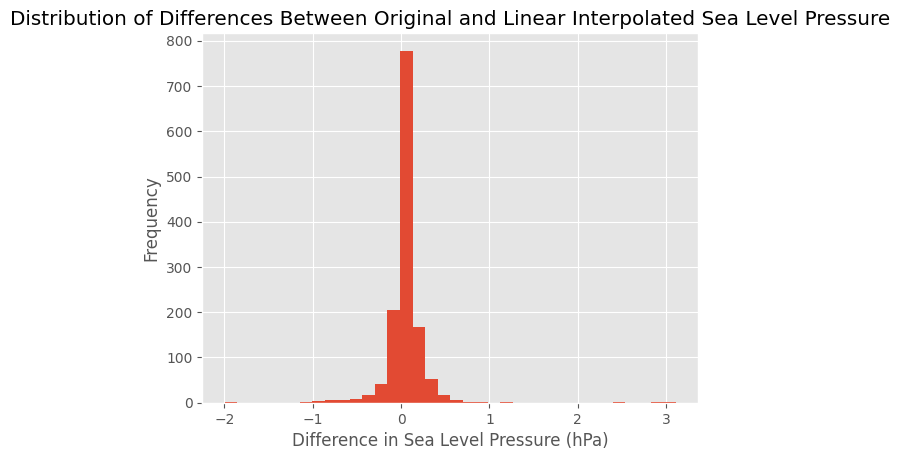

In [72]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate number of bins using the Square Root Rule
num_bins = int(np.sqrt(len(annual_usa_weather_by_state['avg_sea_level_pres_hpa_diff'].dropna())))

# Plot histogram of the differences
plt.hist(annual_usa_weather_by_state['avg_sea_level_pres_hpa_diff'].dropna(), bins=num_bins)
plt.title('Distribution of Differences Between Original and Linear Interpolated Sea Level Pressure')
plt.xlabel('Difference in Sea Level Pressure (hPa)')
plt.ylabel('Frequency')
plt.show()

##### 5.5.3.2 Missing Values vs. Forward Fill

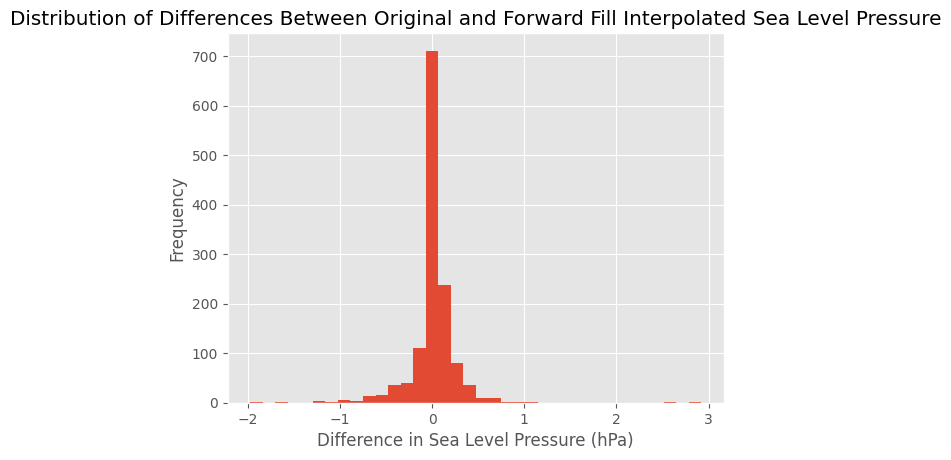

In [79]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate number of bins using the Square Root Rule
num_bins = int(np.sqrt(len(annual_usa_weather_by_state['avg_sea_level_pres_hpa_diff_ffill'].dropna())))

# Plot histogram of the differences
plt.hist(annual_usa_weather_by_state['avg_sea_level_pres_hpa_diff_ffill'].dropna(), bins=num_bins)
plt.title('Distribution of Differences Between Original and Forward Fill Interpolated Sea Level Pressure')
plt.xlabel('Difference in Sea Level Pressure (hPa)')
plt.ylabel('Frequency')
plt.show()

##### 5.5.3.3 Missing Values vs. Backward Fill

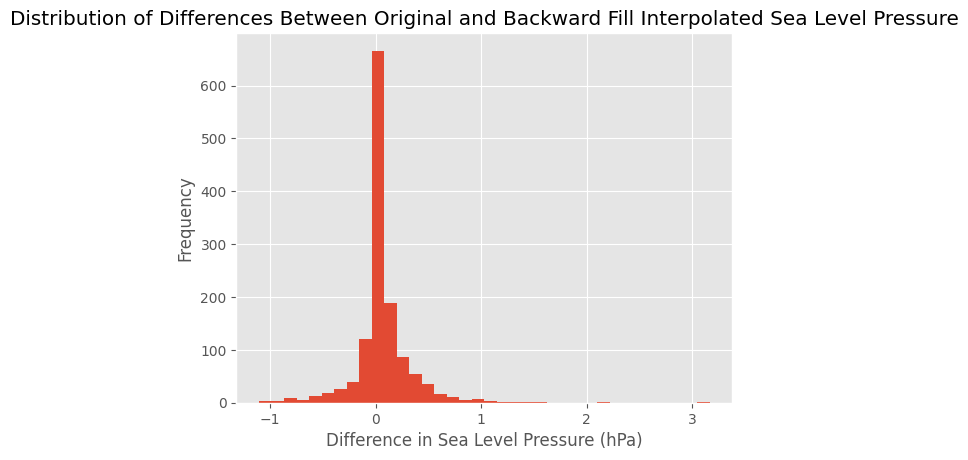

In [80]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate number of bins using the Square Root Rule
num_bins = int(np.sqrt(len(annual_usa_weather_by_state['avg_sea_level_pres_hpa_diff_bfill'].dropna())))

# Plot histogram of the differences
plt.hist(annual_usa_weather_by_state['avg_sea_level_pres_hpa_diff_bfill'].dropna(), bins=num_bins)
plt.title('Distribution of Differences Between Original and Backward Fill Interpolated Sea Level Pressure')
plt.xlabel('Difference in Sea Level Pressure (hPa)')
plt.ylabel('Frequency')
plt.show()

##### 5.5.3.4 Rows where Differences are at Extreme Values

In [ ]:
# Find rows where the difference is at the extreme min and max
extreme_min_row = annual_usa_weather_by_state[annual_usa_weather_by_state['avg_sea_level_pres_hpa_diff'] == annual_usa_weather_by_state['avg_sea_level_pres_hpa_diff'].min()]
extreme_max_row = annual_usa_weather_by_state[annual_usa_weather_by_state['avg_sea_level_pres_hpa_diff'] == annual_usa_weather_by_state['avg_sea_level_pres_hpa_diff'].max()]

# Get index of extreme values
extreme_min_index = extreme_min_row.index[0]
extreme_max_index = extreme_max_row.index[0]

# Look at surrounding rows
rows_around_min = annual_usa_weather_by_state.loc[extreme_min_index - 5:extreme_min_index + 5]
rows_around_max = annual_usa_weather_by_state.loc[extreme_max_index - 5:extreme_max_index + 5]

In [84]:
rows_around_min

,year,state,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,avg_sea_level_pres_hpa,avg_sea_level_pres_hpa_linear,avg_sea_level_pres_hpa_ffill,avg_sea_level_pres_hpa_bfill,latitude,longitude,avg_sea_level_pres_hpa_diff,avg_sea_level_pres_hpa_diff_ffill,avg_sea_level_pres_hpa_diff_bfill
173,1993,Wisconsin,8.19,2.75,13.20,1102.30,1016.79,1016.79,1016.79,1016.79,43.07,-89.40,0.00,0.00,0.00
174,1993,Wyoming,6.78,0.44,13.37,481.90,1015.86,1015.92,1015.92,1015.91,41.14,-104.82,-0.05,-0.06,-0.04
175,1994,Alabama,18.58,12.81,25.08,1504.40,1018.62,1018.62,1018.62,1018.62,32.36,-86.28,0.00,0.00,0.00
176,1994,Alaska,5.32,2.06,8.48,1747.60,NaN,1016.85,1014.60,1018.50,58.31,-134.42,NaN,NaN,NaN
177,1994,Arizona,23.22,16.65,29.77,223.60,1012.03,1012.02,1012.02,1012.02,33.54,-112.07,0.01,0.01,0.01
178,1994,California,14.52,8.02,22.21,87.50,1017.28,1019.28,1019.25,1016.47,38.58,-121.47,-2.00,-1.97,0.81
179,1994,Colorado,11.61,3.99,19.84,279.70,1014.04,1014.04,1014.04,1014.04,39.74,-104.98,0.00,0.00,0.00
180,1994,Connecticut,10.12,4.36,16.06,1340.20,1017.27,1017.25,1017.20,1017.31,41.77,-72.68,0.02,0.07,-0.04
181,1994,Delaware,12.73,7.37,18.02,1153.50,1018.31,1018.30,1018.29,1018.31,39.16,-75.52,0.01,0.01,-0.00
182,1994,District of Columbia,14.32,9.51,19.73,954.70,1018.58,1018.58,1018.58,1018.58,38.90,-77.01,0.00,0.00,0.00


In [85]:
rows_around_max

,year,state,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,avg_sea_level_pres_hpa,avg_sea_level_pres_hpa_linear,avg_sea_level_pres_hpa_ffill,avg_sea_level_pres_hpa_bfill,latitude,longitude,avg_sea_level_pres_hpa_diff,avg_sea_level_pres_hpa_diff_ffill,avg_sea_level_pres_hpa_diff_bfill
254,1995,South Carolina,17.45,11.29,24.23,1399.10,1017.19,1017.19,1017.19,1017.19,34.04,-80.90,0.00,0.00,0.00
255,1995,Tennessee,15.38,9.59,21.17,1240.80,1017.21,1017.21,1017.21,1017.21,36.17,-86.78,0.00,0.00,0.00
256,1995,Utah,12.01,5.64,18.69,430.30,1015.09,1015.09,1015.09,1015.10,40.78,-111.93,-0.00,0.00,-0.01
257,1995,Vermont,-0.64,-5.35,5.59,253.10,NaN,1019.92,1019.40,1020.10,44.26,-72.58,NaN,NaN,NaN
258,1995,Virginia,14.52,8.59,20.52,875.00,1017.60,1017.56,1017.56,1017.56,37.55,-77.45,0.03,0.04,0.03
259,1995,Washington,10.93,4.91,17.23,1394.60,1017.48,1014.37,1014.56,1014.31,47.04,-122.90,3.11,2.92,3.17
260,1995,West Virginia,12.33,6.75,18.32,1144.40,1017.13,1017.11,1017.12,1017.11,38.35,-81.63,0.02,0.01,0.02
261,1995,Wisconsin,8.57,2.79,14.00,854.10,1016.00,1016.00,1016.00,1016.00,43.07,-89.40,0.00,0.00,0.00
262,1995,Wyoming,7.90,1.21,14.73,509.90,1014.89,1014.87,1014.88,1014.87,41.14,-104.82,0.02,0.01,0.03
263,1996,Alabama,17.18,11.01,23.58,1468.10,1018.17,1018.13,1018.14,1018.12,32.36,-86.28,0.04,0.03,0.05


In [96]:
migraine_data

,measure_name,location_name,sex_name,age_name,cause_name,metric_name,year,val,upper,lower
0,YLDs (Years Lived with Disability),Minnesota,Both,All ages,Migraine,Number,1990,29214.94,65881.32,4214.35
1,YLDs (Years Lived with Disability),Minnesota,Both,All ages,Migraine,Percent,1990,0.05,0.10,0.01
2,YLDs (Years Lived with Disability),Minnesota,Both,All ages,Migraine,Rate,1990,654.93,1476.91,94.48
3,YLDs (Years Lived with Disability),Minnesota,Both,All ages,Migraine,Number,1991,29442.34,67467.95,4364.10
4,YLDs (Years Lived with Disability),Minnesota,Both,All ages,Migraine,Percent,1991,0.05,0.10,0.01
...,...,...,...,...,...,...,...,...,...,...
13765,Incidence,Wyoming,Both,All ages,Migraine,Percent,2018,0.00,0.00,0.00
13766,Incidence,Wyoming,Both,All ages,Migraine,Rate,2018,1147.05,1274.03,1013.60
13767,Incidence,Wyoming,Both,All ages,Migraine,Number,2019,6991.17,7765.51,6179.17
13768,Incidence,Wyoming,Both,All ages,Migraine,Percent,2019,0.00,0.00,0.00


### 5.6 Join Migraine Data with Weather Data

Finally, join the migraine data with the combined weather data (countries, cities, daily weather) on the `city_name` column from weather data and on the `location_name` column from the migraine data.

In [106]:
annual_usa_weather_by_state_scenarios = annual_usa_weather_by_state.copy()

In [113]:
# List of columns to keep
columns_to_stay = [col for col in annual_usa_weather_by_state.columns if col not in ['avg_sea_level_pres_hpa', 'avg_sea_level_pres_hpa_ffill', 'avg_sea_level_pres_hpa_bfill', 'avg_sea_level_pres_hpa_diff', 'avg_sea_level_pres_hpa_diff_ffill', 'avg_sea_level_pres_hpa_diff_bfill']]

# Use .loc to select only the columns to keep
annual_usa_weather_by_state = annual_usa_weather_by_state.loc[:, columns_to_stay]

annual_usa_weather_by_state.rename(columns={'avg_sea_level_pres_hpa_linear': 'avg_sea_level_pres_hpa'}, inplace=True)

annual_usa_weather_by_state

,year,state,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,avg_sea_level_pres_hpa,latitude,longitude
0,1990,Alabama,19.22,12.18,26.75,1326.40,1019.33,32.36,-86.28
1,1990,Alaska,5.12,1.67,8.46,1401.50,1014.85,58.31,-134.42
2,1990,Arizona,23.77,17.29,30.63,196.90,1012.34,33.54,-112.07
3,1990,California,15.81,8.80,24.38,349.90,1015.95,38.58,-121.47
4,1990,Colorado,10.53,3.32,18.46,424.30,1014.14,39.74,-104.98
...,...,...,...,...,...,...,...,...,...
1355,2019,Virginia,15.95,10.39,21.93,1090.20,1018.08,37.55,-77.45
1356,2019,Washington,10.19,4.48,16.02,943.30,1017.09,47.04,-122.90
1357,2019,West Virginia,14.08,8.29,20.54,1192.50,1017.65,38.35,-81.63
1358,2019,Wisconsin,8.11,2.97,12.94,1179.50,1017.28,43.07,-89.40


In [119]:
# Combine USA combined weather with migraine data
usa_weather_migraine = annual_usa_weather_by_state.merge(filtered_migraine_data, 
                                      how='left', 
                                      left_on=['year', 'state'], 
                                      right_on=['year', 'state']
                                      )

# Review the shape of the new dataframe
usa_weather_migraine.shape

(1360, 17)

In [120]:
usa_weather_migraine

,year,state,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,avg_sea_level_pres_hpa,latitude,longitude,measure_name,sex_name,age_name,cause_name,metric_name,val,upper,lower
0,1990,Alabama,19.22,12.18,26.75,1326.40,1019.33,32.36,-86.28,Prevalence,Both,All ages,Migraine,Number,743282.57,850504.22,647607.37
1,1990,Alaska,5.12,1.67,8.46,1401.50,1014.85,58.31,-134.42,Prevalence,Both,All ages,Migraine,Number,101075.08,116504.07,87805.46
2,1990,Arizona,23.77,17.29,30.63,196.90,1012.34,33.54,-112.07,Prevalence,Both,All ages,Migraine,Number,660664.95,758621.86,574031.97
3,1990,California,15.81,8.80,24.38,349.90,1015.95,38.58,-121.47,Prevalence,Both,All ages,Migraine,Number,5487919.50,6301624.31,4766693.93
4,1990,Colorado,10.53,3.32,18.46,424.30,1014.14,39.74,-104.98,Prevalence,Both,All ages,Migraine,Number,617571.71,711492.96,537121.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1355,2019,Virginia,15.95,10.39,21.93,1090.20,1018.08,37.55,-77.45,Prevalence,Both,All ages,Migraine,Number,1524550.21,1741025.53,1335624.09
1356,2019,Washington,10.19,4.48,16.02,943.30,1017.09,47.04,-122.90,Prevalence,Both,All ages,Migraine,Number,1259980.52,1436917.83,1103169.38
1357,2019,West Virginia,14.08,8.29,20.54,1192.50,1017.65,38.35,-81.63,Prevalence,Both,All ages,Migraine,Number,314535.49,358363.65,275554.50
1358,2019,Wisconsin,8.11,2.97,12.94,1179.50,1017.28,43.07,-89.40,Prevalence,Both,All ages,Migraine,Number,1001012.63,1142874.83,876799.70


In [121]:
usa_weather_migraine.isnull().sum()

year                      0
state                     0
avg_temp_c                0
min_temp_c                0
max_temp_c                0
precipitation_mm          0
avg_sea_level_pres_hpa    0
latitude                  0
longitude                 0
measure_name              0
sex_name                  0
age_name                  0
cause_name                0
metric_name               0
val                       0
upper                     0
lower                     0
dtype: int64

In [128]:
num_duplicates = usa_weather_migraine.duplicated().sum()

print(f"Number of Duplicates in Final DataFrame: {num_duplicates}")


Number of Duplicates in Final DataFrame: 0


## 6. Feature Engineering

Discussing any new features that were created and why they were created. Also, discuss any features that were dropped and why they were dropped.

### 6.1 New Features

#### 6.1.1 Converting Celsius to Fahrenheit

##### 6.1.1.1 Convert `avg_temp_c` to `avg_temp_f`

In [129]:
from temp_conversion import celsius_to_fahrenheit

usa_weather_migraine['avg_temp_f'] = usa_weather_migraine['avg_temp_c'].apply(celsius_to_fahrenheit)

,year,state,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,avg_sea_level_pres_hpa,latitude,longitude,measure_name,sex_name,age_name,cause_name,metric_name,val,upper,lower,avg_temp_f
0,1990,Alabama,19.22,12.18,26.75,1326.40,1019.33,32.36,-86.28,Prevalence,Both,All ages,Migraine,Number,743282.57,850504.22,647607.37,66.60
1,1990,Alaska,5.12,1.67,8.46,1401.50,1014.85,58.31,-134.42,Prevalence,Both,All ages,Migraine,Number,101075.08,116504.07,87805.46,41.22
2,1990,Arizona,23.77,17.29,30.63,196.90,1012.34,33.54,-112.07,Prevalence,Both,All ages,Migraine,Number,660664.95,758621.86,574031.97,74.79
3,1990,California,15.81,8.80,24.38,349.90,1015.95,38.58,-121.47,Prevalence,Both,All ages,Migraine,Number,5487919.50,6301624.31,4766693.93,60.45
4,1990,Colorado,10.53,3.32,18.46,424.30,1014.14,39.74,-104.98,Prevalence,Both,All ages,Migraine,Number,617571.71,711492.96,537121.41,50.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1355,2019,Virginia,15.95,10.39,21.93,1090.20,1018.08,37.55,-77.45,Prevalence,Both,All ages,Migraine,Number,1524550.21,1741025.53,1335624.09,60.70
1356,2019,Washington,10.19,4.48,16.02,943.30,1017.09,47.04,-122.90,Prevalence,Both,All ages,Migraine,Number,1259980.52,1436917.83,1103169.38,50.34
1357,2019,West Virginia,14.08,8.29,20.54,1192.50,1017.65,38.35,-81.63,Prevalence,Both,All ages,Migraine,Number,314535.49,358363.65,275554.50,57.34
1358,2019,Wisconsin,8.11,2.97,12.94,1179.50,1017.28,43.07,-89.40,Prevalence,Both,All ages,Migraine,Number,1001012.63,1142874.83,876799.70,46.60


##### 6.1.1.2 Convert `min_temp_c` to `min_temp_f`

In [130]:
usa_weather_migraine['min_temp_f'] = usa_weather_migraine['min_temp_c'].apply(celsius_to_fahrenheit)

##### 6.1.1.3 Convert `max_temp_c` to `max_temp_f`

In [ ]:
usa_weather_migraine['max_temp_f'] = usa_weather_migraine['max_temp_c'].apply(celsius_to_fahrenheit)

##### 6.1.1.4 Reorder Temperature Columns

In [138]:
# Reorder temperature columns
temp_col = usa_weather_migraine.pop('avg_temp_f')

# Insert columns at new position
usa_weather_migraine.insert(3, 'avg_temp_f', temp_col)

In [140]:
# Reorder temperature columns
temp_col1 = usa_weather_migraine.pop('min_temp_f')

# Insert columns at new position
usa_weather_migraine.insert(4, 'min_temp_f', temp_col1)

In [141]:
# Reorder temperature columns
temp_col2 = usa_weather_migraine.pop('max_temp_f')

# Insert columns at new position
usa_weather_migraine.insert(5, 'max_temp_f', temp_col2)

In [ ]:
usa_weather_migraine

##### 6.1.1.5 Convert `precipitation_mm` to `precipitation_in`

In [ ]:
from temp_conversion import mM_to_inches

usa_weather_migraine['precipitation_in'] = usa_weather_migraine['precipitation_mm'].apply(mM_to_inches)


In [ ]:
# # Reorder temperature columns
# temp_col3 = usa_weather_migraine.pop('precipitation_in')

# # Insert columns at new position
# usa_weather_migraine.insert(2, 'precipitation_in', temp_col3)

#### 6.1.2 Sea Level Pressure Missing Values

##### 6.1.2.1 Leaving/Dropping Missing Values (Scenario #1)

Utilized existing data without filling in missing values.

##### 6.1.2.2 Linear Interpolation (Scenario #2)

- `avg_sea_level_pres_hpa_linear`: calculated by using linear interpolation to fill in missing values for the average sea level pressure
- `avg_sea_level_pres_hpa_linear_diff`: calculated by subtracting the upper bound of the average sea level pressure with linear interpolation from the lower bound of the average sea level pressure with linear interpolation
- `avg_sea_level_pres_hpa_linear_diff_pct`: calculated by dividing the difference between the upper and lower bounds of the average sea level pressure with linear interpolation by the average sea level pressure with linear interpolation

##### 6.1.2.3 Forward Fill (Scenario #3)

- `avg_sea_level_pres_hpa_ffill`: calculated by using forward fill to fill in missing values for the average sea level pressure
- `avg_sea_level_pres_hpa_ffill_diff`: calculated by subtracting the upper bound of the average sea level pressure with forward fill from the lower bound of the average sea level pressure with forward fill
- `avg_sea_level_pres_hpa_ffill_diff_pct`: calculated by dividing the difference between the upper and lower bounds of the average sea level pressure with forward fill by the average sea level pressure with forward fill

##### 6.1.2.4 Backward Fill (Scenario #4)

- `avg_sea_level_pres_hpa_bfill`: calculated by using backward fill to fill in missing values for the average sea level pressure
- `avg_sea_level_pres_hpa_bfill_diff`: calculated by subtracting the upper bound of the average sea level pressure with backward fill from the lower bound of the average sea level pressure with backward fill
- `avg_sea_level_pres_hpa_bfill_diff_pct`: calculated by dividing the difference between the upper and lower bounds of the average sea level pressure with backward fill by the average sea level pressure with backward fill

### 6.2 Dropped Features

In [134]:
usa_weather_migraine.drop(columns=['avg_temp_c', 'min_temp_c', 'max_temp_c'], inplace=True)

usa_weather_migraine

,year,state,precipitation_mm,avg_sea_level_pres_hpa,latitude,longitude,measure_name,sex_name,age_name,cause_name,metric_name,val,upper,lower,avg_temp_f,min_temp_f,max_temp_f
0,1990,Alabama,1326.40,1019.33,32.36,-86.28,Prevalence,Both,All ages,Migraine,Number,743282.57,850504.22,647607.37,66.60,53.93,80.15
1,1990,Alaska,1401.50,1014.85,58.31,-134.42,Prevalence,Both,All ages,Migraine,Number,101075.08,116504.07,87805.46,41.22,35.00,47.22
2,1990,Arizona,196.90,1012.34,33.54,-112.07,Prevalence,Both,All ages,Migraine,Number,660664.95,758621.86,574031.97,74.79,63.13,87.13
3,1990,California,349.90,1015.95,38.58,-121.47,Prevalence,Both,All ages,Migraine,Number,5487919.50,6301624.31,4766693.93,60.45,47.83,75.88
4,1990,Colorado,424.30,1014.14,39.74,-104.98,Prevalence,Both,All ages,Migraine,Number,617571.71,711492.96,537121.41,50.96,37.97,65.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1355,2019,Virginia,1090.20,1018.08,37.55,-77.45,Prevalence,Both,All ages,Migraine,Number,1524550.21,1741025.53,1335624.09,60.70,50.70,71.47
1356,2019,Washington,943.30,1017.09,47.04,-122.90,Prevalence,Both,All ages,Migraine,Number,1259980.52,1436917.83,1103169.38,50.34,40.06,60.84
1357,2019,West Virginia,1192.50,1017.65,38.35,-81.63,Prevalence,Both,All ages,Migraine,Number,314535.49,358363.65,275554.50,57.34,46.92,68.97
1358,2019,Wisconsin,1179.50,1017.28,43.07,-89.40,Prevalence,Both,All ages,Migraine,Number,1001012.63,1142874.83,876799.70,46.60,37.35,55.29


In [ ]:
# usa_weather_migraine.drop(columns='precipitation_mm', inplace=True)

# usa_weather_migraine

## 7. Summary

Summarize the data preprocessing steps that were taken in this notebook.

## 8. Next Steps

Discuss any next steps that should be taken in the data analysis process/modeling phases.